In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('colorblind')
sns.set_color_codes()

# Modeling

**Problem at hand**:

> Assuming heights of individuals are normally distributed ($Normal(\mu, \sigma$)), find the parameters $\mu$ and $\sigma$ that model the given data accurately.

**Likelihood**: As mentioned above, the heights of individuals ($h_i$) are normally distributed. The _likelihood_ of an individual's height $h_i$ is distributed as $Normal(\mu, \sigma)$.

**Priors**: Assume that $\mu$ is normally distributed with mean 178 and standard deviation 20. Assume that $\sigma$ is uniform between 0 and 50. These are reasonable prior guesses given our prior "domain knowledge" of human heights.

**Model definition**: Here is the model description ($h_i$ is height of i-th individual)

\begin{align}
h_i & \sim Normal(\mu, \sigma) \\
\mu & \sim Normal(178, 20) \\
\sigma & \sim Uniform(0, 50) \\
\end{align}

**Updating priors**: We'll update the priors based on data (likelihood) to get the posteriors for parameters. There are multiple computational techniques for this step - Grid Approximation, finding Maximum A Posteriori using Quadratic Approximation, MCMC (Markov Chain Monte Carlo) Sampling.

**Model checking**: We'll validate the model by simulating data based on posterior parameters and comparing the simulated data against the actual data. There are more sophisticated model checking techniques we'll discuss later.

## Grid Approximation

We'll first tackle this problem by using grid approximation to update our prior beliefs and derive posteriors. We'll later revisit the same problem and use quadratic approximation and MCMC.

Let's first start by reading in the Howell data and exploring it briefly. We'll restrict our analysis to adult heights. 

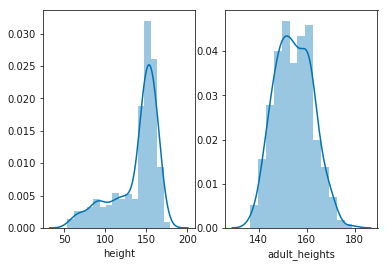

In [2]:
howell = pd.read_csv('data/howell.csv')
adult_heights = howell[howell.age >= 18].height

def plot_heights():
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
    sns.distplot(howell.height, ax=ax1);
    sns.distplot(adult_heights, ax=ax2);
    ax2.set_xlabel('adult_heights');

plot_heights()

In [3]:
mu_grid = np.linspace(50, 300, 100) # 50-300 because center is approximately 178 and covers at least 3sigma
sigma_grid = np.linspace(0.01, 50.01, 100) # Exclude 0. Sigma = 0 makes the likelihood nan. So start at 0.01.
sigma_pdf = stats.uniform.pdf(sigma_grid, 0, 50)
mu_pdf = stats.norm.pdf(mu_grid, 178, 20)

Let's visualize how $\mu$ and $\sigma$ are distributed.

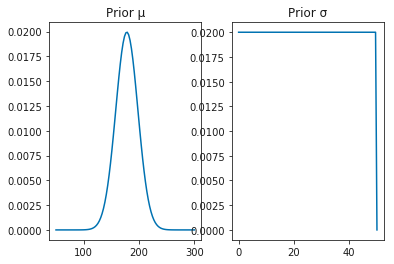

In [4]:
def plot_mu_sigma():
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
    ax1.plot(mu_grid, mu_pdf);
    ax1.set_title('Prior μ');
    ax2.plot(sigma_grid, sigma_pdf);
    ax2.set_title('Prior σ');

plot_mu_sigma()

**NOTE: LogPDF** - The prior values can be really small depending on value of $\mu$ and $\sigma$. When we want to derive the posterior, we need to multiply with likelihoods which can further make these values smaller. To prevent loss of precision we'll use logpdf instead and we will _add_ logpdf of prior and loglikelihood. This will make the computation more accurate. 

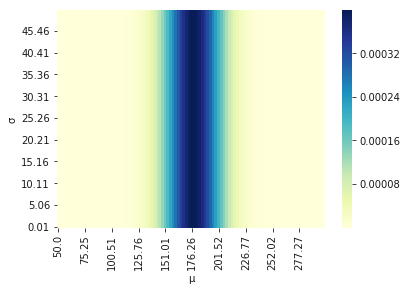

In [5]:
x_mu_grid, y_sigma_grid = np.meshgrid(mu_grid, sigma_grid)
prior_logpdf = stats.norm.logpdf(x_mu_grid, 178, 20) + stats.uniform.logpdf(y_sigma_grid, 0.01, 50.01)

def plot_heatmap_prior():
    z = pd.DataFrame(np.exp(prior_logpdf), index=np.round(sigma_grid, 2), columns=np.round(mu_grid, 2))
    ax = sns.heatmap(z, xticklabels=10, yticklabels=10, cmap="YlGnBu");
    plt.xlabel('μ');
    plt.ylabel('σ');
    ax.invert_yaxis()

plot_heatmap_prior()

The above heatmap describes our prior belief of values of $\mu$ and $\sigma$. 

Given this $\mu$ and $\sigma$ let's simulate the data and figure out how heights simulated using this prior model will look. 

- We'll first draw 10,000 means and sigmas from our priors ($\mu_i$ and $\sigma_i$)
- Then we'll generate heights $h_i$

In [6]:
sampled_mu = stats.norm.rvs(loc=178, scale=20, size=10000)
sampled_sigma = stats.uniform.rvs(loc=0.01, scale=50.01, size=10000)
sampled_h = stats.norm.rvs(loc=sampled_mu, scale=sampled_sigma, size=10000)

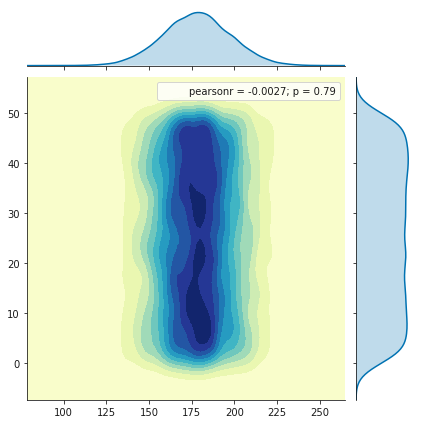

In [7]:
sns.jointplot(x=sampled_mu, y=sampled_sigma, kind="kde", cmap="YlGnBu");

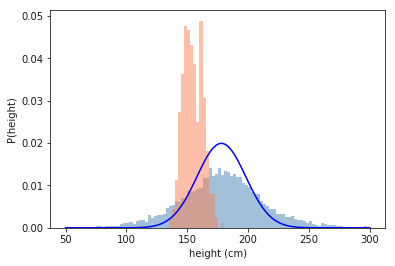

In [8]:
def plot_prior_and_data():
    plt.hist(sampled_h, normed=True, bins=100, range=[50, 300], alpha=0.5, color='steelblue');
    plt.plot(np.linspace(50, 300, 100), stats.norm.pdf(np.linspace(50, 300, 100), loc=178, scale=20), 
             color='blue');
    plt.hist(adult_heights, normed=True, bins=100, range=[50, 300], alpha=0.5, color='coral');
    plt.xlabel('height (cm)');
    plt.ylabel('P(height)');

plot_prior_and_data()

The steel blue is the distribution of heights _generated_ (simulated) by our prior model. Blue line plot above is $Normal(178, 20)$. As expected the generated heights have fatter tails. There is uncertainity in sigma which makes the tails fatter. So far this looks reasonable.

Coral red distribution is the actual distribution of adults heights from the data. Notice that the generated (simulated) data based on our model and the actual data don't look alike. This means our prior model is not accurate. This is not surprising, because our prior was nothing more than a wild guess.

Our goal is to update the prior beliefs based on the data and estimate the right parameters (poterior) for $\mu$ and $\sigma$.

Once we update our beliefs and get the right values for $\mu$ and $\sigma$, we'll generate (simulate) the data again based on the updated posterior beliefs about $\mu$ and $\sigma$ and if all goes well the simulated data based on posterior and observed data should look similar.

\begin{align}
P(\mu,\sigma|h) & = \frac{Normal(\mu|178,20)*Uniform(\sigma|0, 50)\prod_i{Normal(h_i|\mu,\sigma)}}{\int_{\mu}{\int_{\sigma}Normal(\mu|178,20)*Uniform(\sigma|0, 50)\prod_i{Normal(h_i|\mu,\sigma) \,d\sigma \,d\mu}}}
\end{align}

<img src="images/bayes_visualization.jpg" width="480" style="align:left;" />

In [9]:
likelihood_logpdf = np.zeros(prior_logpdf.shape)
for h in adult_heights:
    likelihood_logpdf += stats.norm.logpdf(h, loc=x_mu_grid, scale=y_sigma_grid)
posterior_logpdf = likelihood_logpdf + prior_logpdf

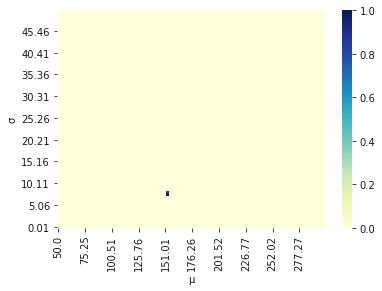

In [10]:
def plot_heatmap_posterior(posterior, mu_grid, sigma_grid):
    # Hack: Why do we plot np.exp(posterior_logpdf - posterior_logpdf.max()) 
    # instead of np.exp(posterior_grid)? 
    # Because posterior_logpdf
    # .min() = -37315129573.01 and .max() = -1231.56
    # These values are so small that np.exp(posterior_pdf) ranges from 0 to 0.
    # We are essentially rescaling the values so that max of np.exp(...) = 1.
    z = pd.DataFrame(np.exp(posterior - posterior.max()), 
                     index=np.round(sigma_grid, 2), columns=np.round(mu_grid, 2))
    ax = sns.heatmap(z, xticklabels=10, yticklabels=10, cmap="YlGnBu");
    plt.xlabel('μ');
    plt.ylabel('σ');
    ax.invert_yaxis()

plot_heatmap_posterior(posterior_logpdf, mu_grid, sigma_grid)

**Sidenote: Why does the posterior look like a dot?**

Why does the posterior look like a dot? It's because we have a lot of data and the posterior is a very narrow peak centered approxmilately around $\mu=154.5$ and $\sigma=7.7$. How do we solve this? Easy. Let's zoom in on the region between $\sigma \in (7, 8.5)$ and $\mu \in (153, 156)$

Note: It's not easy to see the exact values. I zoomed in a couple of times by trial and error to get the right region for $\mu$ and $\sigma$

In [11]:
mu_grid = np.linspace(153, 156, 100)
sigma_grid = np.linspace(7, 8.5, 100)
x_mu_grid, y_sigma_grid = np.meshgrid(mu_grid, sigma_grid)
prior_logpdf = stats.norm.logpdf(x_mu_grid, 178, 20) + stats.uniform.logpdf(y_sigma_grid, 0.01, 50.01)
likelihood_logpdf = np.zeros(prior_logpdf.shape)
for h in adult_heights:
    likelihood_logpdf += stats.norm.logpdf(h, loc=x_mu_grid, scale=y_sigma_grid)
posterior_logpdf_numerator = likelihood_logpdf + prior_logpdf
posterior_pdf_unscaled = np.exp(posterior_logpdf_numerator - posterior_logpdf_numerator.max())
posterior_pdf = posterior_pdf_unscaled / posterior_pdf_unscaled.sum()
posterior_pdf.max(), posterior_pdf.min(), posterior_pdf.sum()

(0.00061209665133476522, 1.4164115778322399e-09, 1.0)

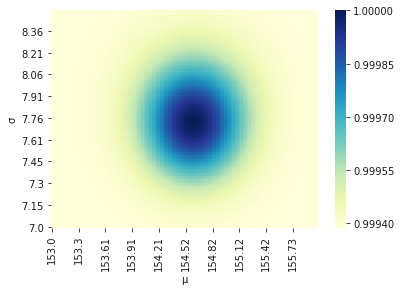

In [12]:
plot_heatmap_posterior(posterior_pdf, mu_grid, sigma_grid)

## Model checking

Let's now sample $\mu$ and $\sigma$ from the posterior and generate (simulate) heights and check against the actual data to see if they are comparable. This is a way to check if our model is sound.

<img src="images/sampling_from_posterior.jpg" width="480" />

In [13]:
x = np.random.choice(np.arange(0, 10000), 10000, p=posterior_pdf.reshape(100 * 100))
sampled_mu = x_mu_grid.reshape(10000)[x]
sampled_sigma = y_sigma_grid.reshape(10000)[x]
heights_simulated = stats.norm.rvs(loc=sampled_mu, scale=sampled_sigma, size=10000)

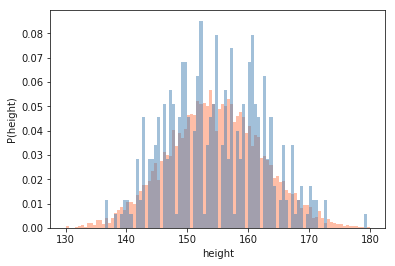

In [14]:
def plot_simulated_data():
    plt.hist(heights_simulated, normed=True, bins=100, range=[130, 180], alpha=0.5, color='coral');
    plt.hist(adult_heights, normed=True, bins=100, range=[130, 180], alpha=0.5, color='steelblue');
    plt.xlabel('height');
    plt.ylabel('P(height)');

plot_simulated_data()

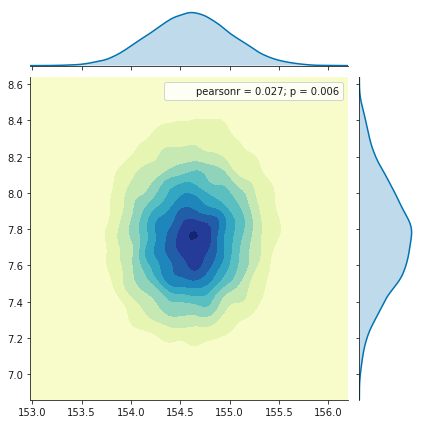

In [15]:
sns.jointplot(sampled_mu, sampled_sigma, kind="kde", cmap="YlGnBu");

## Maximum A Posteriori (MAP) using Quadratic approximation

In [16]:
with pm.Model() as HeightModel:
    mu = pm.Normal('mu', 178, 20)
    sigma = pm.Uniform('sigma', 0, 50)
    hi = pm.Normal('hi', mu=mu, sd=sigma, observed=adult_heights)

    map_locations = pm.find_MAP()
    map_scales = (1/pm.find_hessian(map_locations))**0.5

logp = -1,227.9, ||grad|| = 0.008076: 100%|██████████| 31/31 [00:00<00:00, 2373.34it/s]  


In [17]:
map_locations, map_scales

({'mu': array(154.6056671142578, dtype=float32),
  'sigma': array(7.731353282928467, dtype=float32),
  'sigma_interval__': array(-1.6987615823745728, dtype=float32)},
 array([[ 0.41199505,         nan],
        [        nan,  0.04457115]], dtype=float32))

In [18]:
# Note that `sigma_interval__` is an "interval transformed" version of sigma.
# Uniform(0, 50) has a support of (0, 50). But a lot of optimization algorithms
# expect support to be the entire set of real numbers. To accomplish this,
# pymc3 automatically transforms sigma to sigma_interval__ using an interval 
# transformation.
# forward transformation: x -> log(x - a) - log(b - x)
# backward transformation: x -> (b - a) * sigmoid(x) + a
# https://github.com/pymc-devs/pymc3/blob/2e987d957b/pymc3/distributions/transforms.py#L126
# See: https://stackoverflow.com/a/42170938/553995
sigma_unif = pm.distributions.transforms.interval(0, 50)
# .eval() because t returns a theano tensor which needs to be eval'ed
sigma = sigma_unif.backward(map_locations['sigma_interval__']).eval()

In [19]:
map_mu_loc, map_sigma_loc = map_locations['mu'], sigma

In [20]:
map_mu_loc, map_sigma_loc

(array(154.6056671142578, dtype=float32),
 array(7.731354236602783, dtype=float32))

In [21]:
map_scales

array([[ 0.41199505,         nan],
       [        nan,  0.04457115]], dtype=float32)

In [22]:
map_mu_scale, map_sigma_scale = np.diag(map_scales)

In [23]:
map_mu_scale, map_sigma_scale

(0.41199505, 0.044571146)

In [24]:
# FIXME. Figure out a better way
(sigma_unif.backward(map_locations['sigma_interval__']+3*map_sigma_scale).eval() 
    - sigma_unif.backward(map_locations['sigma_interval__']-3*map_sigma_scale).eval())/6

0.29149810575649332

In [25]:
0.292**2

0.08526399999999999

In [26]:
0.412**2

0.16974399999999998

## MCMC sampling

**TODO**: Add MCMC here

# Linear Regression

Now let's turn to modeling height vs. weight.

\begin{align}
h_i \sim Normal(\mu_i, \sigma) \\
\mu_i = \alpha + \beta x_i \\
\alpha \sim Normal(178, 100) \\
\beta \sim Normal(0, 10) \\
\sigma \sim Uniform(0, 50) \\
\end{align}

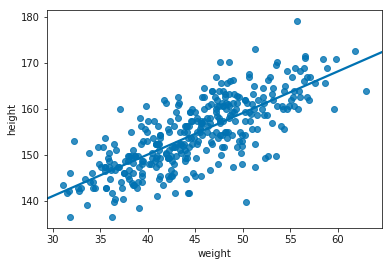

In [27]:
# Only consider adults
adult_heights = howell[howell.age >= 18].height
adult_weights = howell[howell.age >= 18].weight
sns.regplot(adult_weights, adult_heights, ci=0);

In [28]:
def height_weight_linear_regression(heights, weights):
    with pm.Model() as linear_model:
        alpha = pm.Normal('alpha', mu=178, sd=100)
        beta = pm.Normal('beta', mu=0, sd=10)
        sigma = pm.Uniform('sigma', lower=0.01, upper=50.01)
        mu = alpha + beta * weights
        # mu = pm.Deterministic('mu', alpha + beta * adult_weights) 
        # try uncomenting this line and comenting the above line
        height = pm.Normal('height', mu=mu, sd=sigma, observed=heights)
        trace = pm.sample(2000)
        return linear_model, trace

linear_model, trace = height_weight_linear_regression(adult_heights, adult_weights)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
 99%|█████████▉| 2480/2500 [00:08<00:00, 278.89it/s]//anaconda/envs/rethinking/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.87916142048, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 2500/2500 [00:08<00:00, 279.03it/s]


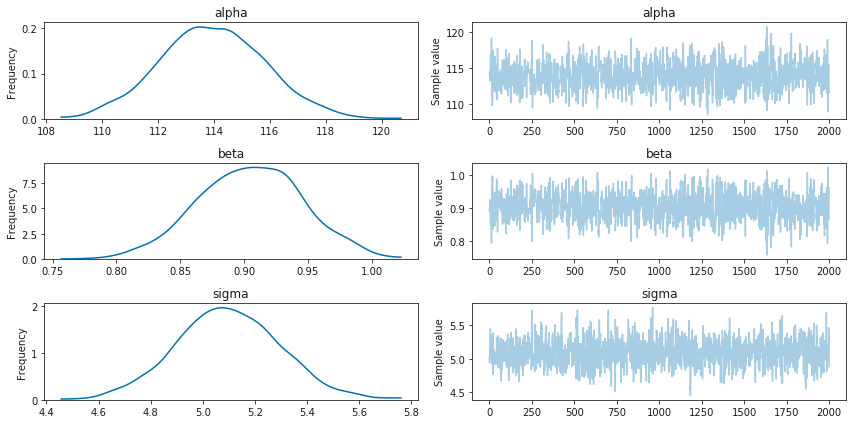

In [29]:
pm.traceplot(trace);

**Sampling from the posterior**

What do we have here? What are the plots above? We _directly sampled from the posterior_. What does it mean? Recall in the previous section where we used grid approximation to first find values of $\mu$ and $\sigma$. Then we _sampled_ values of ($\mu$, $\sigma$) from the posterior and simulated heights as $Normal(\mu, \sigma)$. Here we skipped the grid approximation and posterior computations and directly sampled from the posterior using Markov Chain Monte Carlo techniques (discussed later). The internals of MCMC sampling are not important at the moment. What is important is the understanding that the above plots are not magical. The plots represent our _posterior beliefs_ of the distributions of parameters $\alpha$, $\beta$ and $\sigma$. In this case we sampled 2000 points $(\alpha, \beta, \sigma)$ from the posterior distribution (`pm.sample(2000)`).

PyMC3 returns a `Trace` object as a result of the sampling. This `Trace` can be converted to a Pandas DataFrame for further manipulation.

In [30]:
pm.df_summary(trace, alpha=0.11)

,mean,sd,mc_error,hpd_5.5,hpd_94.5
alpha,113.922798,1.864582,0.060818,110.983994,116.950706
beta,0.904172,0.041095,0.001331,0.841630,0.974141
sigma,5.094675,0.198255,0.006136,4.757003,5.386016


In [31]:
trace_df = pm.trace_to_dataframe(trace)
trace_df.head()

,alpha,beta,sigma
0,114.237610,0.889222,5.010526
1,114.306046,0.896744,4.937768
2,114.536758,0.894023,4.993716
3,113.213425,0.924148,5.207275
4,114.562225,0.888612,5.091191


Let's plot a scatter matrix (pair plot) of all the values $\alpha$, $\beta$ and $\sigma$ to see if there are any patterns.

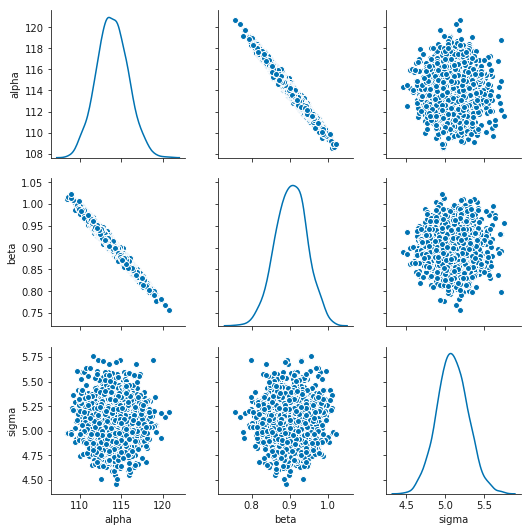

In [32]:
sns.pairplot(trace_df, diag_kind="kde");

In [33]:
trace_df.corr().round(2)

,alpha,beta,sigma
alpha,1.00,-0.99,0.01
beta,-0.99,1.00,-0.01
sigma,0.01,-0.01,1.00


$\alpha$ and $\beta$ are highly correlated! In more complex models, strong correlations between parameters such as these can make it really hard to fit the models. There are ways of preprocessing the data to remove this correlation between the parameters - $\alpha$ and $\beta$. Let's do that now.

## Correlation and Data Preprocessing - Centering

One trick for removing correlation between $\alpha$ and $\beta$ is _centering_ the predictor variable (sutracting the _mean_), in our case _weight_. We'll center the weight and redo the analysis and compute the correlation between $\alpha$ and $\beta$ again.

In [34]:
adult_weights_centered = adult_weights - adult_weights.mean()

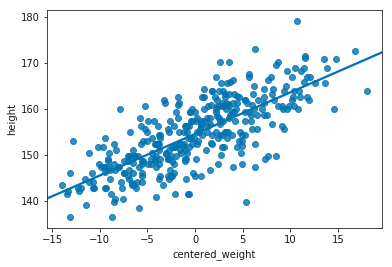

In [35]:
ax = sns.regplot(adult_weights_centered, adult_heights, ci=0);
ax.set_xlabel('centered_weight');

In [36]:
trace_c = height_weight_linear_regression(adult_heights, adult_weights_centered)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2500/2500 [00:02<00:00, 1073.80it/s]


In [37]:
trace_c

(<pymc3.model.Model at 0x1c1f285cc0>,
 <MultiTrace: 1 chains, 2000 iterations, 4 variables>)

In [38]:
trace_c_df = pm.trace_to_dataframe(trace_c[1])

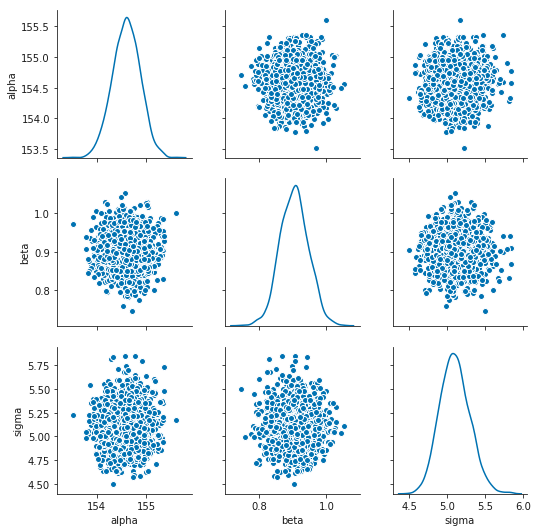

In [39]:
sns.pairplot(trace_c_df, diag_kind="kde");

In [40]:
trace_c_df.corr().round(2)

,alpha,beta,sigma
alpha,1.00,0.00,0.02
beta,0.00,1.00,-0.03
sigma,0.02,-0.03,1.00


The correlation between $\alpha$ and $\beta$ dropped to -0.01 (uncorrelated, after centering) from (-1.0, prior to centering). So centering helped.

## Visualizing parameters - fit and uncertainty

In the trace plot above we've seen the distributions of $\alpha$, $\beta$ and $\sigma$ which help us visualize the uncertainty in those parameters. But what we are really interested in is the uncertainty in $\mu$ and more importantly uncertainty in heights generated (simulated) by our model. This will help us sanity check the model as well.

### Plotting  $\mu$ vs Weight
First let's visualize $\mu$ as a function of $weight$. There are _many_ possible values of $\alpha$ and $\beta$. So there are many possible lines for $\mu$. Which one should we plot? First it's reasonable to start with mean values of $\alpha$ and $\beta$. Let's plot that line.

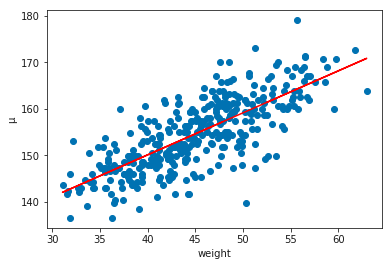

In [41]:
def plot_weight_mu_trace_mean(trace):
    plt.scatter(adult_weights, adult_heights);
    plt.plot(adult_weights, trace['alpha'].mean() + trace['beta'].mean() * adult_weights, color='red');
    plt.xlabel('weight');
    plt.ylabel('μ');

plot_weight_mu_trace_mean(trace)

### Plotting Multiple Lines - $\mu$ vs $weight$
By eyeballing this we can see that this line fits the data well. But notice there are infinite number of lines that fit the data. Not just one! Each value of $\alpha$ and $\beta$ generates a new line. Some lines are more probable than others. Because some values of $\alpha$ and $\beta$ are more probable than others (see traceplot at the beginning of Linear Regression section).

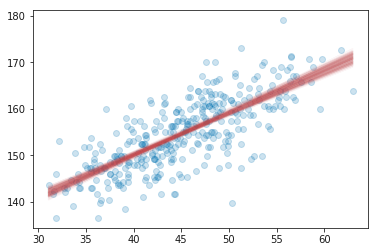

In [42]:
def plot_fit_lines():
    plt.scatter(adult_weights, adult_heights, alpha=0.2);
    samples = trace_df.sample(100)
    for _, sample in samples.iterrows():
        plt.plot(adult_weights, sample.alpha + sample.beta * adult_weights, 'r-', alpha=0.05);

plot_fit_lines()

In the above plot we plotted 100 of the many possible lines by sampling 100 values for $\alpha$ and $\beta$. As you'll notice there is a darker region in the middle where a lot of lines overlap. Lines in this region are _more probable_ than other lines.

### Visualizing how uncertainty of $\mu$ changes with more data
It is hard to see this region and uncertainty in the lines from figure above. Let's use the same model and reduce the data. We'll fit the lines and start increasing the data and see how the lines are going to cluster more and more as we add more data.

In [43]:
num_elements = [10, 50, 150, 352]
heights = []
weights = []
traces = []
for i, n in enumerate(num_elements):
    heights.append(adult_heights[:n])
    weights.append(adult_weights[:n])
    traces.append(height_weight_linear_regression(heights[i], weights[i]))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|█████████▉| 2499/2500 [00:06<00:00, 363.52it/s]//anaconda/envs/rethinking/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 5 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 2500/2500 [00:06<00:00, 363.36it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2500/2500 [00:08<00:00, 288.16it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2500/2500 [00:09<00:00, 272.09it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|█████████▉| 2490/2500 [00:09<00:00, 255.02it/s]//anaconda/envs/rethinking/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0

In [44]:
traces

[(<pymc3.model.Model at 0x1c1f28af98>,
  <MultiTrace: 1 chains, 2000 iterations, 4 variables>),
 (<pymc3.model.Model at 0x1c1f4d0978>,
  <MultiTrace: 1 chains, 2000 iterations, 4 variables>),
 (<pymc3.model.Model at 0x1c1e545160>,
  <MultiTrace: 1 chains, 2000 iterations, 4 variables>),
 (<pymc3.model.Model at 0x1c1e6710b8>,
  <MultiTrace: 1 chains, 2000 iterations, 4 variables>)]

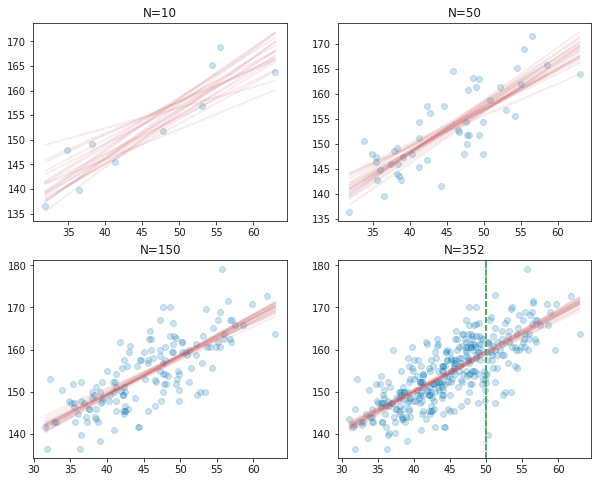

In [45]:
def plot_fit_lines_multiple_plots():
    fig, ax = plt.subplots(2, 2, figsize=(10, 8))
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            m = i * 2 + j
            col.scatter(weights[m], heights[m], alpha=0.2);
            trace_df_i = pm.trace_to_dataframe(traces[m][1])
            samples = trace_df_i.sample(20)
            for _, sample in samples.iterrows():
                col.plot(weights[m], sample.alpha + sample.beta * weights[m], 'r-', alpha=0.1);
                col.set_title('N=%s' % num_elements[m])
                if m == 3:
                    col.axvline(x=50, color='g', linestyle='--')


plot_fit_lines_multiple_plots()

In the figures above, we started with 10 points. There are many possible lines and the lines are spread out, because given our data, all of them are likely to be good fits. But as we add more data, the lines start clustering more and more at the center and the fit gets better and better.

The uncertainty in $\mu$ changes with $weight$ since $\mu$ is a function of $weight$. To understand it a bit better, let's take a cross-section at $weight = 50$ and plot the distribution of $\mu$.

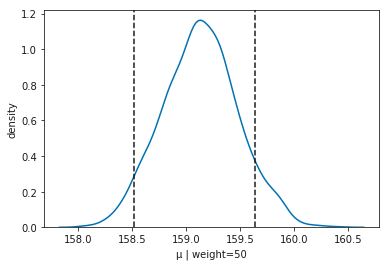

In [46]:
def plot_mu_at_50():
    samples = pm.trace_to_dataframe(traces[3][1])
    mu_at_50 = samples.alpha + samples.beta * 50
    ax = sns.kdeplot(mu_at_50);
    ax.set_xlabel('μ | weight=50');
    ax.set_ylabel('density');
    hpd_min, hpd_max = pm.hpd(mu_at_50, alpha=.11)
    plt.axvline(x=hpd_min, color='k', linestyle='--')
    plt.axvline(x=hpd_max, color='k', linestyle='--')

plot_mu_at_50()

### Visualizing the HPD of $\mu$ vs Weight
A common way of visualizing uncertainty in $\mu$ as the weight varies, is by plotting the mean line and shade the HPD of $\mu$ around it.

In [47]:
def compute_mu_mean_hpd():
    weight_seq = np.arange(30, 70)
    mu_pred = np.zeros((len(weight_seq), trace_df.shape[0]))
    for i, w in enumerate(weight_seq):
        mu_pred[i] = trace_df['alpha'] + trace_df['beta'] * w
    
    mu_hpd = pm.hpd(mu_pred.T, alpha=0.11)
    mu_mean = mu_pred.mean(axis=1)
    
    return mu_mean, mu_hpd

In [48]:
def plot_mu_hpd():
    weight_seq = np.arange(30, 70)
    plt.scatter(adult_weights, adult_heights, c='b', alpha=0.2);
    plt.plot(weight_seq, mu_mean, 'r');
    plt.fill_between(weight_seq, mu_hpd[:,0], mu_hpd[:,1], color='r', alpha=0.4);
    plt.xlabel('weight', fontsize=14);
    plt.ylabel('μ', fontsize=14);

In [49]:
mu_mean, mu_hpd = compute_mu_mean_hpd()

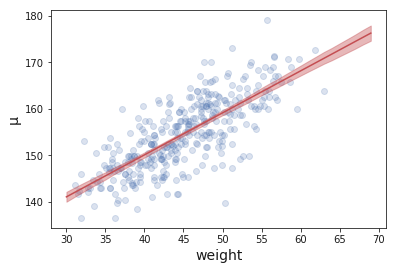

In [50]:
plot_mu_hpd()

## Posterior Predictive Checks

In [51]:
# hpd computes values across rows by default. We need HPD for each "person", i.e we need to
# compute HPD across rows. So transpose it first. If you're unsure check the "shape".

# FIXME.
# person_hpds = pm.hpd(person_mu_values.T)

In [52]:
samples = pm.sample_ppc(trace, samples=500, model=linear_model)

100%|██████████| 500/500 [00:00<00:00, 2334.65it/s]


samples

In [53]:
samples

{'height': array([[ 155.5514315 ,  136.62063791,  145.89128296, ...,  152.30674076,
          144.61689117,  158.16536756],
        [ 158.0611479 ,  145.45599708,  149.2315    , ...,  162.43951177,
          171.10386638,  157.18935539],
        [ 163.28334116,  148.35371419,  145.43938201, ...,  167.31853754,
          163.592692  ,  162.9081107 ],
        ..., 
        [ 151.84560134,  148.48020989,  143.86739411, ...,  170.21733505,
          154.86033998,  159.5628972 ],
        [ 148.29513636,  151.87772671,  142.10078028, ...,  160.23272346,
          161.68854884,  161.44928649],
        [ 159.87369652,  148.97636214,  135.29466327, ...,  162.34442172,
          161.50156825,  159.3853306 ]])}

### References  

- Remove patch objects in outputs (https://stackoverflow.com/questions/14506583/suppress-output-of-object-when-plotting-in-ipython)